,POS,Count,Proportion
0,ADP,279635,0.220066
1,DET,240975,0.189641
2,PRON,211393,0.166361
3,VERB,142201,0.111909
4,CONJ,126453,0.099515
5,OTHER,68556,0.053952
6,ADV,67912,0.053445
7,PART,56564,0.044514
8,NOUN,34726,0.027328
9,ADJ,26889,0.021161


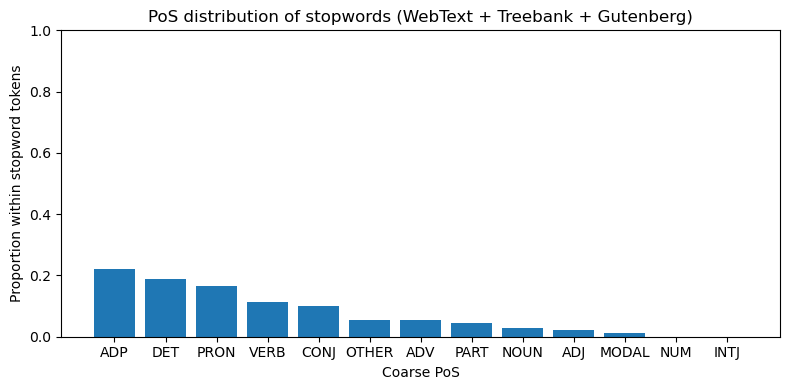

WordNet coverage: 88 / 198 stopwords (44.44%).
Decompressing cc.en.300.bin.gz ...

Top-5 most similar stopword pairs:


,word1,word2,similarity
4894,couldn't,wouldn't,0.937139
14090,shouldn't,wouldn't,0.930594
4759,couldn't,didn't,0.905883
4843,couldn't,shouldn't,0.894125
5480,didn't,wouldn't,0.889482



Top-5 most dissimilar stopword pairs:


,word1,word2,similarity
3776,below,she's,-0.102522
3872,between,haven't,-0.102143
3720,below,he's,-0.099929
4327,by,hasn,-0.097998
13223,ours,you'll,-0.085901


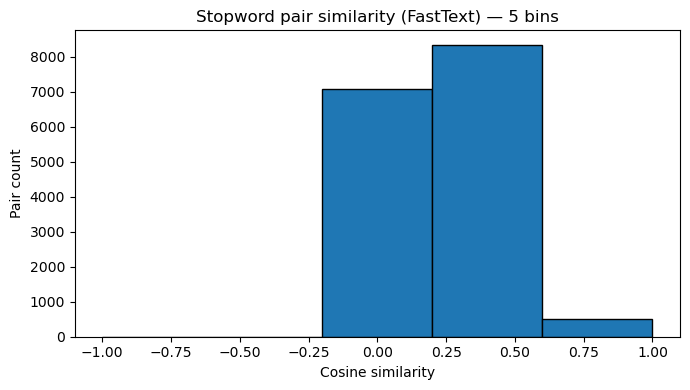


Saved files (relative):
- artifacts/spec2_pos_distribution.csv
- artifacts/spec2_pos_distribution.png
- artifacts/spec2_wordnet_coverage.csv
- artifacts/spec2_similarity_pairs.csv
- artifacts/spec2_top5_similar.csv
- artifacts/spec2_top5_dissimilar.csv
- artifacts/spec2_similarity_hist.png


In [3]:
# Spec 2 (full): PoS + WordNet + FastText similarity
# Saves all results to artifacts/

import os, gzip, shutil, nltk, pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

# ---------- paths ----------
ART_DIR = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
DATA_DIR = os.path.abspath("../data"      if os.path.basename(os.getcwd())=="notebooks" else "./data")
os.makedirs(ART_DIR, exist_ok=True); os.makedirs(DATA_DIR, exist_ok=True)

# ---------- NLTK resources ----------
for pkg in ['stopwords','webtext','treebank','gutenberg','punkt',
            'averaged_perceptron_tagger','averaged_perceptron_tagger_eng','wordnet','omw-1.4']:
    nltk.download(pkg, quiet=True)

from nltk.corpus import stopwords, webtext, treebank, gutenberg, wordnet
from nltk import pos_tag

# ---------- helpers ----------
def yield_corpus_words():
    """Lowercase alphabetic tokens from WebText, Treebank, Gutenberg."""
    for fid in webtext.fileids():
        for w in webtext.words(fid):
            w=w.lower()
            if w.isalpha(): yield w
    for w in treebank.words():
        w=w.lower()
        if w.isalpha(): yield w
    for fid in gutenberg.fileids():
        for w in gutenberg.words(fid):
            w=w.lower()
            if w.isalpha(): yield w

def batched(iterable, size=8000):
    """Yield lists of up to size items."""
    buf=[]
    for x in iterable:
        buf.append(x)
        if len(buf)>=size:
            yield buf; buf=[]
    if buf: yield buf

def penn_to_coarse(tag):
    """Map Penn tag to coarse PoS."""
    if tag.startswith('NN'): return 'NOUN'
    if tag.startswith('VB'): return 'VERB'
    if tag.startswith('JJ'): return 'ADJ'
    if tag.startswith('RB'): return 'ADV'
    if tag=='DT': return 'DET'
    if tag=='IN': return 'ADP'
    if tag in ('PRP','PRP$'): return 'PRON'
    if tag=='CC': return 'CONJ'
    if tag=='TO': return 'PART'
    if tag=='MD': return 'MODAL'
    if tag=='UH': return 'INTJ'
    if tag=='CD': return 'NUM'
    return 'OTHER'

# ---------- stopwords L ----------
L = set(stopwords.words('english'))

# =========================
# Part A — PoS distribution
# =========================
pos_counts = Counter()
for chunk in batched(yield_corpus_words(), size=8000):
    for w, t in pos_tag(chunk):
        if w in L:
            pos_counts[penn_to_coarse(t)] += 1

total_tagged = sum(pos_counts.values())
pos_rows = sorted(((k, v, (v/total_tagged if total_tagged else 0.0)) for k,v in pos_counts.items()),
                  key=lambda x: x[2], reverse=True)
df_pos = pd.DataFrame(pos_rows, columns=['POS','Count','Proportion'])
display(df_pos)

pos_csv = os.path.join(ART_DIR, "spec2_pos_distribution.csv")
df_pos.to_csv(pos_csv, index=False)

plt.figure(figsize=(8,4))
plt.bar(df_pos['POS'], df_pos['Proportion'])
plt.ylim(0,1); plt.ylabel('Proportion within stopword tokens')
plt.xlabel('Coarse PoS'); plt.title('PoS distribution of stopwords (WebText + Treebank + Gutenberg)')
plt.tight_layout()
pos_png = os.path.join(ART_DIR, "spec2_pos_distribution.png")
plt.savefig(pos_png, dpi=150); plt.show()

# =========================
# Part B — WordNet coverage
# =========================
cov_rows=[]; has_cnt=0
for w in sorted(L):
    syns = wordnet.synsets(w)
    flag = int(len(syns)>0)
    has_cnt += flag
    cov_rows.append({'word': w, 'in_wordnet': bool(flag), 'synset_count': len(syns)})
df_wn = pd.DataFrame(cov_rows)
wn_csv = os.path.join(ART_DIR, "spec2_wordnet_coverage.csv")
df_wn.to_csv(wn_csv, index=False)
print(f"WordNet coverage: {has_cnt} / {len(L)} stopwords ({(has_cnt/len(L))*100:.2f}%).")

# ==========================================
# Part C — FastText similarity (handles .gz)
# ==========================================
from gensim.models import KeyedVectors, fasttext as ft_api

# expected model files
ft_bin      = os.path.join(DATA_DIR, "cc.en.300.bin")
ft_vec      = os.path.join(DATA_DIR, "cc.en.300.vec")
ft_bin_gz   = os.path.join(DATA_DIR, "cc.en.300.bin.gz")
ft_vec_gz   = os.path.join(DATA_DIR, "cc.en.300.vec.gz")

# if gz exists, decompress once to data/
def _gunzip(src, dst):
    with gzip.open(src, 'rb') as f_in, open(dst, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

if (not os.path.exists(ft_bin)) and os.path.exists(ft_bin_gz):
    print("Decompressing cc.en.300.bin.gz ...")
    _gunzip(ft_bin_gz, ft_bin)
if (not os.path.exists(ft_vec)) and os.path.exists(ft_vec_gz):
    print("Decompressing cc.en.300.vec.gz ...")
    _gunzip(ft_vec_gz, ft_vec)

model = None
if os.path.exists(ft_bin):
    model = ft_api.load_facebook_vectors(ft_bin)   # binary facebook format
elif os.path.exists(ft_vec):
    model = KeyedVectors.load_word2vec_format(ft_vec, binary=False)

similarity_done = model is not None
if not similarity_done:
    print("NOTE: FastText model not found under data/ (cc.en.300.bin[.gz] or .vec[.gz]). Skipping similarity.")
else:
    # keep only words present in the model vocab
    L_vocab = sorted([w for w in L if w in model.key_to_index])
    pairs = []
    for i in range(len(L_vocab)):
        wi = L_vocab[i]
        vi = model.get_vector(wi)
        for j in range(i+1, len(L_vocab)):
            wj = L_vocab[j]
            vj = model.get_vector(wj)
            sim = float(np.dot(vi, vj) / (np.linalg.norm(vi)*np.linalg.norm(vj)))
            pairs.append((wi, wj, sim))

    df_sim = pd.DataFrame(pairs, columns=['word1','word2','similarity'])
    sim_csv = os.path.join(ART_DIR, "spec2_similarity_pairs.csv")
    df_sim.to_csv(sim_csv, index=False)

    # top-5 similar and top-5 dissimilar
    top5  = df_sim.sort_values('similarity', ascending=False).head(5)
    bot5  = df_sim.sort_values('similarity', ascending=True).head(5)
    top5_csv = os.path.join(ART_DIR, "spec2_top5_similar.csv")
    bot5_csv = os.path.join(ART_DIR, "spec2_top5_dissimilar.csv")
    top5.to_csv(top5_csv, index=False); bot5.to_csv(bot5_csv, index=False)

    print("\nTop-5 most similar stopword pairs:")
    display(top5)
    print("\nTop-5 most dissimilar stopword pairs:")
    display(bot5)

    # histogram with 5 equal bins over [-1, 1]
    bins = np.linspace(-1.0, 1.0, 6)
    plt.figure(figsize=(7,4))
    plt.hist(df_sim['similarity'].values, bins=bins, edgecolor='black')
    plt.title('Stopword pair similarity (FastText) — 5 bins')
    plt.xlabel('Cosine similarity'); plt.ylabel('Pair count')
    plt.tight_layout()
    hist_png = os.path.join(ART_DIR, "spec2_similarity_hist.png")
    plt.savefig(hist_png, dpi=150); plt.show()

# ---------- summary print (relative paths) ----------
print("\nSaved files (relative):")
print(f"- artifacts/{os.path.basename(pos_csv)}")
print(f"- artifacts/{os.path.basename(pos_png)}")
print(f"- artifacts/{os.path.basename(wn_csv)}")
if similarity_done:
    print(f"- artifacts/{os.path.basename(sim_csv)}")
    print(f"- artifacts/{os.path.basename(top5_csv)}")
    print(f"- artifacts/{os.path.basename(bot5_csv)}")
    print(f"- artifacts/{os.path.basename(hist_png)}")
else:
    print("- FastText outputs skipped.")
